![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.Clinical_Named_Entity_Recognition_Model.ipynb)

# Clinical Named Entity Recognition (NER)

## Colab Setup

In [10]:
import json

with open('license_keys.json') as f_in:
    license_keys = json.load(f_in)

license_keys.keys()


dict_keys(['secret', 'SPARK_NLP_LICENSE', 'JSL_OCR_LICENSE', 'AWS_ACCESS_KEY_ID', 'AWS_SECRET_ACCESS_KEY', 'JSL_OCR_SECRET'])

In [ ]:
# template for license_key.json

{'secret':"xxx",
'SPARK_NLP_LICENSE': 'aaa',
'JSL_OCR_LICENSE': 'bbb',
'AWS_ACCESS_KEY_ID':"ccc",
'AWS_SECRET_ACCESS_KEY':"ddd",
'JSL_OCR_SECRET':"eee"}

In [ ]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4

secret = license_keys['secret']
os.environ['SPARK_NLP_LICENSE'] = license_keys['SPARK_NLP_LICENSE']
os.environ['JSL_OCR_LICENSE'] = license_keys['JSL_OCR_LICENSE']
os.environ['AWS_ACCESS_KEY_ID']= license_keys['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = license_keys['AWS_SECRET_ACCESS_KEY']

! python -m pip install --upgrade spark-nlp-jsl==2.4.2  --extra-index-url https://pypi.johnsnowlabs.com/$secret

import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl


def start(secret):
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "8G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "900M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5") \
        .config("spark.jars", "https://pypi.johnsnowlabs.com/"+secret+"/spark-nlp-jsl-2.4.2.jar")
      
    return builder.getOrCreate()


In [4]:
import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl


In [5]:
import sparknlp
spark = sparknlp.start()

In [6]:
posology_ner = NerDLModel.pretrained("ner_posology", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")

ner_posology download started this may take some time.
Approximate size to download 13.7 MB
[OK!]


In [ ]:
import sparknlp

sparknlp.version()

'2.4.5'

In [ ]:
spark = start(secret) # if you want to start the session with custom params as in start function above
# sparknlp_jsl.start(secret)

In [ ]:
spark

# Clinical NER Pipeline (with pretrained models)

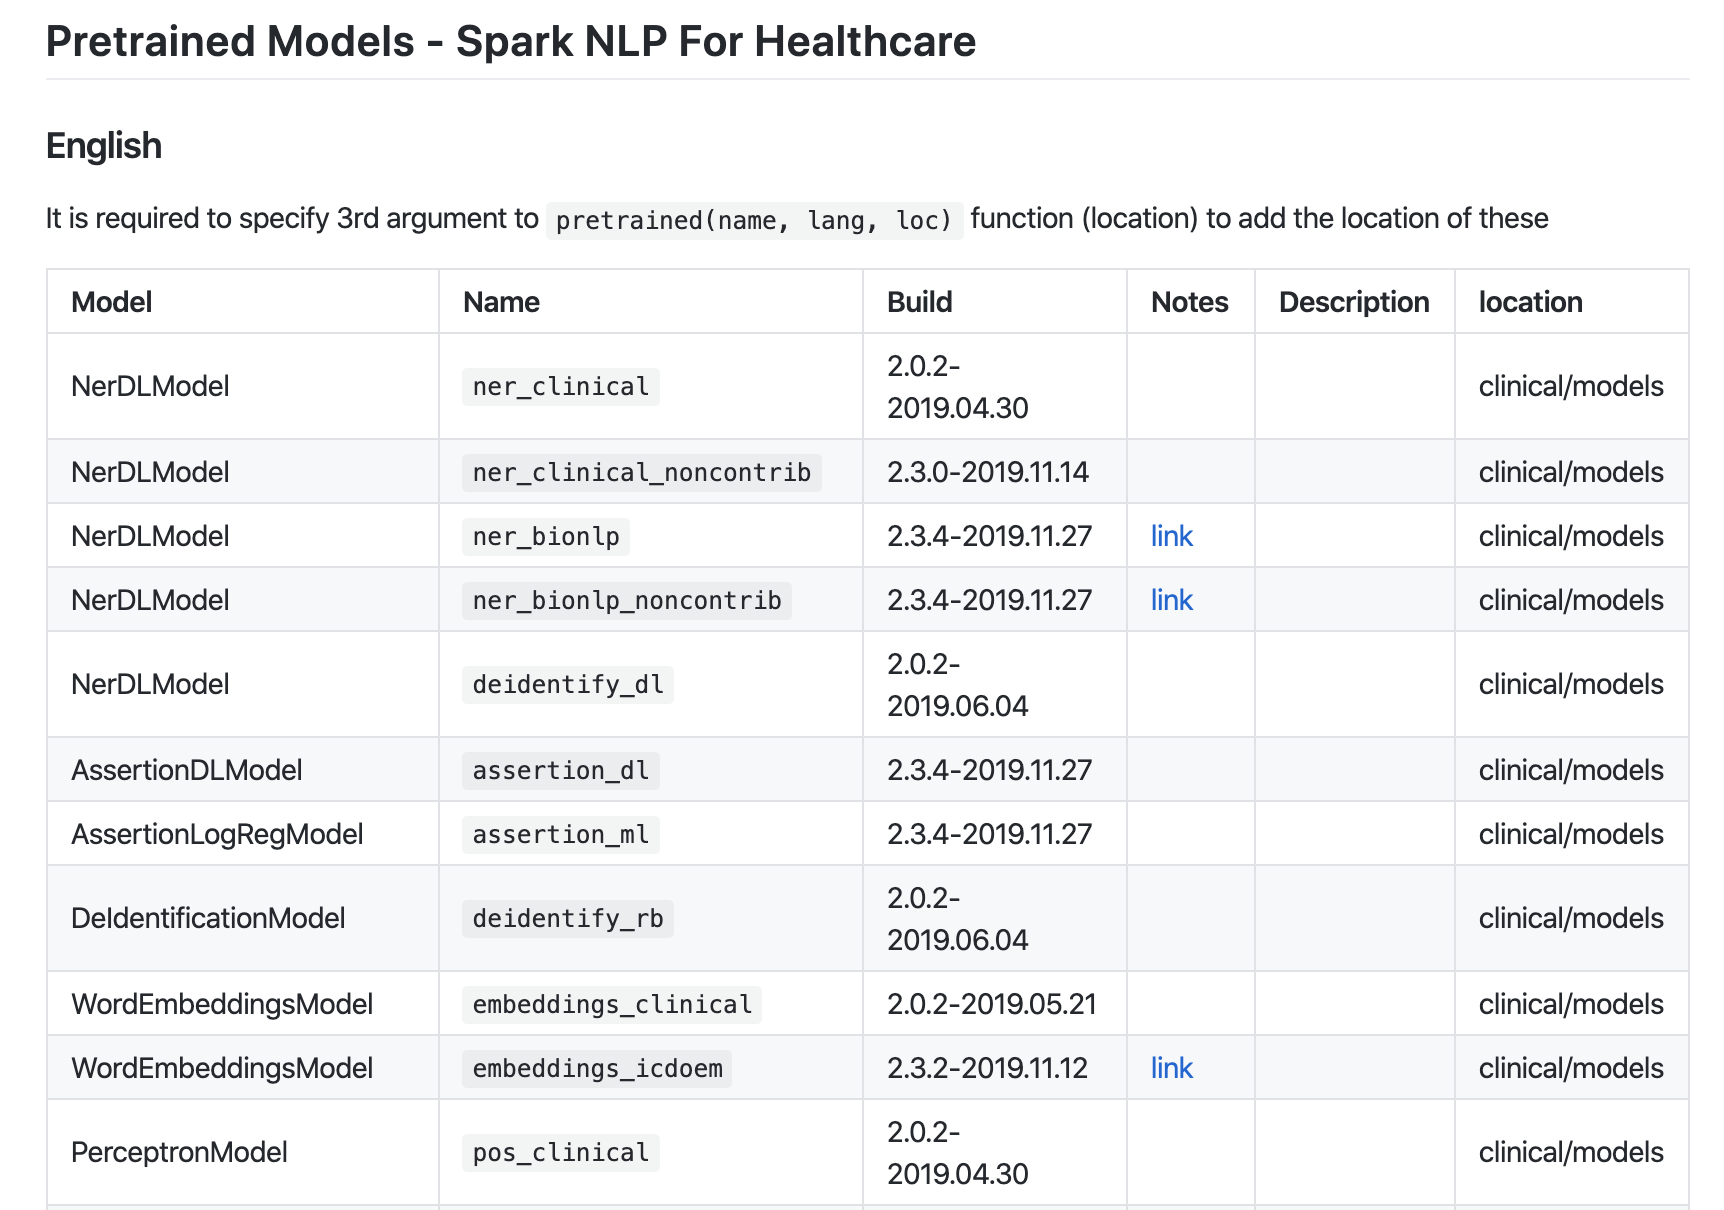

In [ ]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP

documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line

sentenceDetector = SentenceDetector()\
  .setInputCols(["document"])\
  .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

# NER model trained on i2b2 (sampled from MIMIC) dataset
clinical_ner = NerDLModel.pretrained("ner_clinical", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")

ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


In [ ]:
! wget 	https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/pubmed/pubmed_sample_text_small.csv


--2020-04-09 17:17:59--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/pubmed/pubmed_sample_text_small.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.105.61
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.105.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9363435 (8.9M) [text/csv]
Saving to: ‘pubmed_sample_text_small.csv’

pubmed_sample_text_ 100%[===================>]   8.93M  32.7MB/s    in 0.3s    

2020-04-09 17:17:59 (32.7 MB/s) - ‘pubmed_sample_text_small.csv’ saved [9363435/9363435]



In [ ]:
import pyspark.sql.functions as F

pubMedDF = spark.read\
                .option("header", "true")\
                .csv("pubmed_sample_text_small.csv")\
                
pubMedDF.show(truncate=50)

+--------------------------------------------------+
|                                              text|
+--------------------------------------------------+
|The human KCNJ9 (Kir 3.3, GIRK3) is a member of...|
|BACKGROUND: At present, it is one of the most i...|
|OBJECTIVE: To investigate the relationship betw...|
|Combined EEG/fMRI recording has been used to lo...|
|Kohlschutter syndrome is a rare neurodegenerati...|
|Statistical analysis of neuroimages is commonly...|
|The synthetic DOX-LNA conjugate was characteriz...|
|Our objective was to compare three different me...|
|We conducted a phase II study to assess the eff...|
|"""Monomeric sarcosine oxidase (MSOX) is a flav...|
|We presented the tachinid fly Exorista japonica...|
|The literature dealing with the water conductin...|
|A novel approach to synthesize chitosan-O-isopr...|
|An HPLC-ESI-MS-MS method has been developed for...|
|The localizing and lateralizing values of eye a...|
|OBJECTIVE: To evaluate the effectiveness and 

In [ ]:
pubMedDF.printSchema()

root
 |-- text: string (nullable = true)



In [ ]:
result = model.transform(pubMedDF.limit(100))

In [ ]:
result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|The human KCNJ9 (...|[[document, 0, 95...|[[document, 0, 12...|[[token, 0, 2, Th...|[[word_embeddings...|[[named_entity, 0...|[[chunk, 17, 19, ...|
|BACKGROUND: At pr...|[[document, 0, 14...|[[document, 0, 19...|[[token, 0, 9, BA...|[[word_embeddings...|[[named_entity, 0...|[[chunk, 67, 79, ...|
|OBJECTIVE: To inv...|[[document, 0, 15...|[[document, 0, 30...|[[token, 0, 8, OB...|[[word_embeddings...|[[named_entity, 0...|[[chunk, 130, 152...|
|Combined EEG/fMRI...|[[document, 0, 16...|[[document, 0, 16...|[[token, 0, 7, Co...|[[word_embeddings...|

In [ ]:
result_df = result.select(F.explode(F.arrays_zip('token.result', 'ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ner_label"))

result_df.show(50, truncate=100)


+-------------------+-----------+
|              token|  ner_label|
+-------------------+-----------+
|                The|          O|
|              human|          O|
|              KCNJ9|          O|
|                  (|          O|
|                Kir|     B-TEST|
|                3.3|          O|
|                  ,|          O|
|              GIRK3|     B-TEST|
|                  )|          O|
|                 is|          O|
|                  a|          O|
|             member|          O|
|                 of|          O|
|                the|          O|
|G-protein-activated|          O|
|           inwardly|          O|
|         rectifying|          O|
|          potassium|          O|
|                  (|          O|
|               GIRK|          O|
|                  )|          O|
|            channel|          O|
|             family|          O|
|                  .|          O|
|               Here|          O|
|                 we|          O|
|           de

In [ ]:
result_df.select("token", "ner_label").groupBy('ner_label').count().orderBy('count', ascending=False).show(truncate=False)

+-----------+-----+
|ner_label  |count|
+-----------+-----+
|O          |13366|
|I-PROBLEM  |1554 |
|I-TREATMENT|940  |
|B-PROBLEM  |879  |
|I-TEST     |735  |
|B-TEST     |699  |
|B-TREATMENT|639  |
+-----------+-----+



In [ ]:
result.select(F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.metadata')).alias("cols")) \
.select(F.expr("cols['0']").alias("chunk"),
        F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

+---------------------------------------------+---------+
|chunk                                        |ner_label|
+---------------------------------------------+---------+
|Kir                                          |TEST     |
|GIRK3                                        |TEST     |
|chromosome 1q21-23                           |TREATMENT|
|a candidate gene forType II diabetes mellitus|PROBLEM  |
|coding exons                                 |TEST     |
|byapproximately                              |TEST     |
|introns                                      |TEST     |
|single nucleotide polymorphisms (SNPs        |PROBLEM  |
|aVal366Ala substitution                      |TREATMENT|
|an 8 base-pair                               |PROBLEM  |
|bp)                                          |TEST     |
|Ourexpression studies                        |TEST     |
|The characterization of the KCNJ9 gene       |TEST     |
|furtherstudies                               |TREATMENT|
|KCNJ9 protein

In [ ]:
# fullAnnotate in LightPipeline

text = '''
A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation . Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia . The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission . However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L . The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again . The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours . Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely . She had close follow-up with endocrinology post discharge .
'''

print (text)

light_model = LightPipeline(model)

light_result = light_model.fullAnnotate(text)


chunks = []
entities = []
sentence= []
begin = []
end = []

for n in light_result[0]['ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    sentence.append(n.metadata['sentence'])
    
    
import pandas as pd

df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                   'sentence_id':sentence, 'entities':entities})

df.head(20)


A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation . Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonat

,chunks,begin,end,sentence_id,entities
0,gestational diabetes mellitus,40,68,0,PROBLEM
1,type two diabetes mellitus,129,154,0,PROBLEM
2,"T2DM ),",158,164,0,PROBLEM
3,HTG-induced pancreatitis,187,210,0,PROBLEM
4,an acute hepatitis,264,281,0,PROBLEM
5,obesity,289,295,0,PROBLEM
6,a body mass index,302,318,0,PROBLEM
7,BMI ) of 33.5 kg/m2,322,340,0,PROBLEM
8,polyuria,381,388,0,PROBLEM
9,polydipsia,392,401,0,PROBLEM


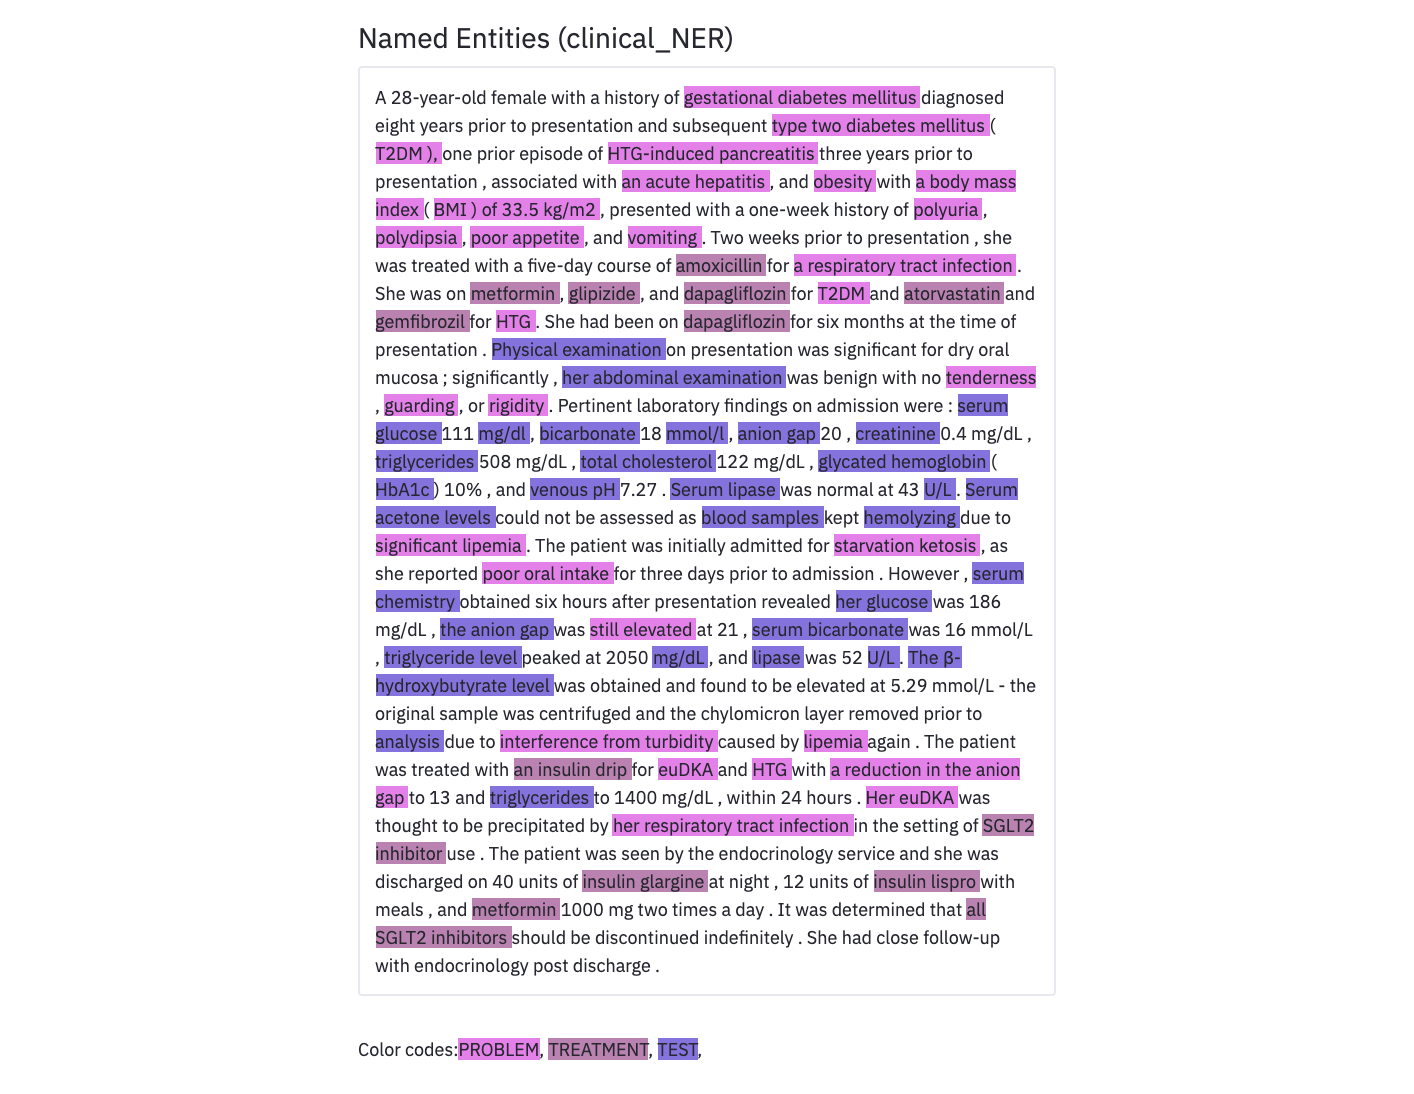

## Posology NER

In [ ]:
ner_converter

NerConverter_b04449096d11

In [ ]:
# NER model trained on i2b2 (sampled from MIMIC) dataset
posology_ner = NerDLModel.pretrained("ner_posology", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")


nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

posology_model = nlpPipeline.fit(empty_data)


ner_posology download started this may take some time.
Approximate size to download 13.7 MB
[OK!]


In [ ]:
posology_result = posology_model.transform(pubMedDF.limit(100))

In [ ]:
posology_result.show(10)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|The human KCNJ9 (...|[[document, 0, 95...|[[document, 0, 12...|[[token, 0, 2, Th...|[[word_embeddings...|[[named_entity, 0...|                  []|
|BACKGROUND: At pr...|[[document, 0, 14...|[[document, 0, 19...|[[token, 0, 9, BA...|[[word_embeddings...|[[named_entity, 0...|[[chunk, 167, 180...|
|OBJECTIVE: To inv...|[[document, 0, 15...|[[document, 0, 30...|[[token, 0, 8, OB...|[[word_embeddings...|[[named_entity, 0...|                  []|
|Combined EEG/fMRI...|[[document, 0, 16...|[[document, 0, 16...|[[token, 0, 7, Co...|[[word_embeddings...|

In [ ]:
posology_result.printSchema()

root
 |-- text: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- sentence: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

# This will return a new DF with all the columns + id
posology_result = posology_result.withColumn("id", monotonically_increasing_id())

posology_result.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk| id|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---+
|The human KCNJ9 (...|[[document, 0, 95...|[[document, 0, 12...|[[token, 0, 2, Th...|[[word_embeddings...|[[named_entity, 0...|                  []|  0|
|BACKGROUND: At pr...|[[document, 0, 14...|[[document, 0, 19...|[[token, 0, 9, BA...|[[word_embeddings...|[[named_entity, 0...|[[chunk, 167, 180...|  1|
|OBJECTIVE: To inv...|[[document, 0, 15...|[[document, 0, 30...|[[token, 0, 8, OB...|[[word_embeddings...|[[named_entity, 0...|                  []|  2|
+--------------------+--------------------+--------------------+------------------

In [ ]:
posology_result.select('token.result','ner.result').take(2)

[Row(result=['The', 'human', 'KCNJ9', '(', 'Kir', '3.3', ',', 'GIRK3', ')', 'is', 'a', 'member', 'of', 'the', 'G-protein-activated', 'inwardly', 'rectifying', 'potassium', '(', 'GIRK', ')', 'channel', 'family', '.', 'Here', 'we', 'describe', 'the', 'genomicorganization', 'of', 'the', 'KCNJ9', 'locus', 'on', 'chromosome', '1q21-23', 'as', 'a', 'candidate', 'gene', 'forType', 'II', 'diabetes', 'mellitus', 'in', 'the', 'Pima', 'Indian', 'population', '.', 'The', 'gene', 'spansapproximately', '7.6', 'kb', 'and', 'contains', 'one', 'noncoding', 'and', 'two', 'coding', 'exons', 'separated', 'byapproximately', '2.2', 'and', 'approximately', '2.6', 'kb', 'introns', ',', 'respectively', '.', 'We', 'identified14', 'single', 'nucleotide', 'polymorphisms', '(', 'SNPs', '),', 'including', 'one', 'that', 'predicts', 'aVal366Ala', 'substitution', ',', 'and', 'an', '8', 'base-pair', '(', 'bp', ')', 'insertion/deletion', '.', 'Ourexpression', 'studies', 'revealed', 'the', 'presence', 'of', 'the', 'tran

In [ ]:
from pyspark.sql import functions as F

posology_result_df = posology_result.select(F.explode(F.arrays_zip('token.result', 'ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ner_label"))\
        .filter("ner_label!='O'")

posology_result_df.show(20, truncate=100)


+----------------+-----------+
|           token|  ner_label|
+----------------+-----------+
|  anthracyclines|     B-DRUG|
|         taxanes|     B-DRUG|
|     vinorelbine|     B-DRUG|
|     vinorelbine|     B-DRUG|
|  anthracyclines|     B-DRUG|
|         taxanes|     B-DRUG|
|  Vinorelbinewas|     B-DRUG|
|              25| B-STRENGTH|
|          mg/m(2| I-STRENGTH|
|   intravenously|    B-ROUTE|
|              on|B-FREQUENCY|
|            days|I-FREQUENCY|
|tumorprogression|     B-DRUG|
| thatvinorelbine|     B-DRUG|
|  anthracyclines|     B-DRUG|
|         taxanes|     B-DRUG|
|     tetrazolium|     B-DRUG|
|             dye|     I-DRUG|
|             DOX|     B-DRUG|
|    trandolapril|     B-DRUG|
+----------------+-----------+
only showing top 20 rows



In [ ]:
posology_result.select('id',F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.begin', 'ner_chunk.end', 'ner_chunk.metadata')).alias("cols")) \
.select('id', F.expr("cols['3']['sentence']").alias("sentence_id"),
        F.expr("cols['0']").alias("chunk"),
        F.expr("cols['1']").alias("begin"),
        F.expr("cols['2']").alias("end"),
        F.expr("cols['3']['entity']").alias("ner_label"))\
        .filter("ner_label!='O'")\
        .show(truncate=False)

+---+-----------+----------------+-----+----+---------+
|id |sentence_id|chunk           |begin|end |ner_label|
+---+-----------+----------------+-----+----+---------+
|1  |0          |anthracyclines  |167  |180 |DRUG     |
|1  |0          |taxanes         |186  |192 |DRUG     |
|1  |1          |vinorelbine     |246  |256 |DRUG     |
|1  |1          |vinorelbine     |386  |396 |DRUG     |
|1  |1          |anthracyclines  |433  |446 |DRUG     |
|1  |1          |taxanes         |452  |458 |DRUG     |
|1  |2          |Vinorelbinewas  |470  |483 |DRUG     |
|1  |2          |25 mg/m(2       |517  |525 |STRENGTH |
|1  |2          |intravenously   |528  |540 |ROUTE    |
|1  |2          |on days         |542  |548 |FREQUENCY|
|1  |3          |tumorprogression|635  |650 |DRUG     |
|1  |10         |thatvinorelbine |1263 |1277|DRUG     |
|1  |10         |anthracyclines  |1380 |1393|DRUG     |
|1  |10         |taxanes         |1399 |1405|DRUG     |
|6  |2          |tetrazolium dye |432  |446 |DRU

In [ ]:
posology_result.select('ner_chunk').take(2)[1][0][0].result

'anthracyclines'

In [ ]:
posology_result.select('ner_chunk').take(2)[1][0][0].metadata

{'chunk': '0', 'entity': 'DRUG', 'sentence': '0'}

### with LightPipelines

In [ ]:
light_model = LightPipeline(posology_model)

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_result = light_model.annotate(text)

list(zip(light_result['token'], light_result['ner']))

[('The', 'O'),
 ('patient', 'O'),
 ('was', 'O'),
 ('prescribed', 'O'),
 ('1', 'B-DOSAGE'),
 ('capsule', 'B-FORM'),
 ('of', 'O'),
 ('Advil', 'B-DRUG'),
 ('for', 'B-DURATION'),
 ('5', 'I-DURATION'),
 ('days', 'I-DURATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('was', 'O'),
 ('seen', 'O'),
 ('by', 'O'),
 ('the', 'O'),
 ('endocrinology', 'O'),
 ('service', 'O'),
 ('and', 'O'),
 ('she', 'O'),
 ('was', 'O'),
 ('discharged', 'O'),
 ('on', 'O'),
 ('40', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('glargine', 'I-DRUG'),
 ('at', 'B-FREQUENCY'),
 ('night', 'I-FREQUENCY'),
 (',', 'O'),
 ('12', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('lispro', 'I-DRUG'),
 ('with', 'B-FREQUENCY'),
 ('meals', 'I-FREQUENCY'),
 (',', 'O'),
 ('and', 'O'),
 ('metformin', 'B-DRUG'),
 ('1000', 'B-STRENGTH'),
 ('mg', 'I-STRENGTH'),
 ('two', 'B-FREQUENCY'),
 ('times', 'I-FREQUENCY'),
 ('a', 'I-FREQUENCY'),
 ('day', 'I-FREQUENCY'),
 ('.', 'O'),
 ('It', 'O'),
 ('was

In [ ]:
light_result = light_model.fullAnnotate(text)

chunks = []
entities = []
begin =[]
end = []

for n in light_result[0]['ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    
import pandas as pd

df = pd.DataFrame({'chunks':chunks, 'entities':entities,
                   'begin': begin, 'end': end})

df

,chunks,entities,begin,end
0,gestational diabetes mellitus,PROBLEM,40,68
1,type two diabetes mellitus,PROBLEM,129,154
2,"T2DM ),",PROBLEM,158,164
3,HTG-induced pancreatitis,PROBLEM,187,210
4,an acute hepatitis,PROBLEM,264,281
...,...,...,...,...
66,SGLT2 inhibitor,TREATMENT,2158,2172
67,insulin glargine,TREATMENT,2268,2283
68,insulin lispro,TREATMENT,2308,2321
69,metformin,TREATMENT,2340,2348


## Writing a generic NER function

In [ ]:
def get_base_pipeline (embeddings = 'embeddings_clinical'):

  documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

  # Sentence Detector annotator, processes various sentences per line

  sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

  # Tokenizer splits words in a relevant format for NLP

  tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

  # Clinical word embeddings trained on PubMED dataset
  word_embeddings = WordEmbeddingsModel.pretrained(embeddings, "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

  empty_data = spark.createDataFrame([[""]]).toDF("text")

  model = nlpPipeline.fit(empty_data)

  return model



def get_clinical_entities (embeddings, spark_df, nrows = 100, model_name = 'ner_clinical'):

  # NER model trained on i2b2 (sampled from MIMIC) dataset
  loaded_ner_model = NerDLModel.pretrained(model_name, "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

  ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")

  base_model = get_base_pipeline (embeddings)

  nlpPipeline = Pipeline(stages=[
      base_model,
      loaded_ner_model,
      ner_converter])

  empty_data = spark.createDataFrame([[""]]).toDF("text")

  model = nlpPipeline.fit(empty_data)

  result = model.transform(spark_df.limit(nrows))

  result = result.withColumn("id", monotonically_increasing_id())

  result_df = result.select('id',F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.begin', 'ner_chunk.end', 'ner_chunk.metadata')).alias("cols")) \
  .select('id', F.expr("cols['3']['sentence']").alias("sentence_id"),
          F.expr("cols['0']").alias("chunk"),
          F.expr("cols['1']").alias("begin"),
          F.expr("cols['2']").alias("end"),
          F.expr("cols['3']['entity']").alias("ner_label"))\
          .filter("ner_label!='O'")

  return result_df

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_clinical'

nrows = 100

ner_df = get_clinical_entities (embeddings, pubMedDF, nrows, model_name)

ner_df.show()

ner_clinical download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
+---+-----------+--------------------+-----+---+---------+
| id|sentence_id|               chunk|begin|end|ner_label|
+---+-----------+--------------------+-----+---+---------+
|  0|          0|                 Kir|   17| 19|     TEST|
|  0|          0|               GIRK3|   26| 30|     TEST|
|  0|          1|  chromosome 1q21-23|  188|205|TREATMENT|
|  0|          1|a candidate gene ...|  210|254|  PROBLEM|
|  0|          2|        coding exons|  357|368|     TEST|
|  0|          2|     byapproximately|  380|394|     TEST|
|  0|          2|             introns|  425|431|     TEST|
|  0|          3|single nucleotide...|  464|500|  PROBLEM|
|  0|          3|aVal366Ala substi...|  532|554|TREATMENT|
|  0|          3|      an 8 base-pair|  561|574|  PROBLEM|
|  0|          4|              

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_posology'

nrows = 100

ner_df = get_clinical_entities (embeddings, pubMedDF, nrows, model_name)

ner_df.show()

ner_posology download started this may take some time.
Approximate size to download 13.7 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
+---+-----------+----------------+-----+----+---------+
| id|sentence_id|           chunk|begin| end|ner_label|
+---+-----------+----------------+-----+----+---------+
|  1|          0|  anthracyclines|  167| 180|     DRUG|
|  1|          0|         taxanes|  186| 192|     DRUG|
|  1|          1|     vinorelbine|  246| 256|     DRUG|
|  1|          1|     vinorelbine|  386| 396|     DRUG|
|  1|          1|  anthracyclines|  433| 446|     DRUG|
|  1|          1|         taxanes|  452| 458|     DRUG|
|  1|          2|  Vinorelbinewas|  470| 483|     DRUG|
|  1|          2|       25 mg/m(2|  517| 525| STRENGTH|
|  1|          2|   intravenously|  528| 540|    ROUTE|
|  1|          2|         on days|  542| 548|FREQUENCY|
|  1|          3|tumorprogression|  635| 650|     DRUG|
|  1|         

In [ ]:
import pandas as pd

def get_clinical_entities_light (light_model, text):

  light_result = light_model.fullAnnotate(text)

  chunks = []
  entities = []

  for n in light_result[0]['ner_chunk']:
          
      chunks.append(n.result)
      entities.append(n.metadata['entity']) 
      
  df = pd.DataFrame({'chunks':chunks, 'entities':entities})

  return df

In [ ]:
text ='The patient was prescribed 1 capsle of Parol with meals . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_model = LightPipeline(posology_model)

get_clinical_entities_light (light_model, text)


,chunks,entities
0,1,DOSAGE
1,capsle,FORM
2,Parol,DRUG
3,with meals,FREQUENCY
4,40 units,DOSAGE
5,insulin glargine,DRUG
6,at night,FREQUENCY
7,12 units,DOSAGE
8,insulin lispro,DRUG
9,with meals,FREQUENCY


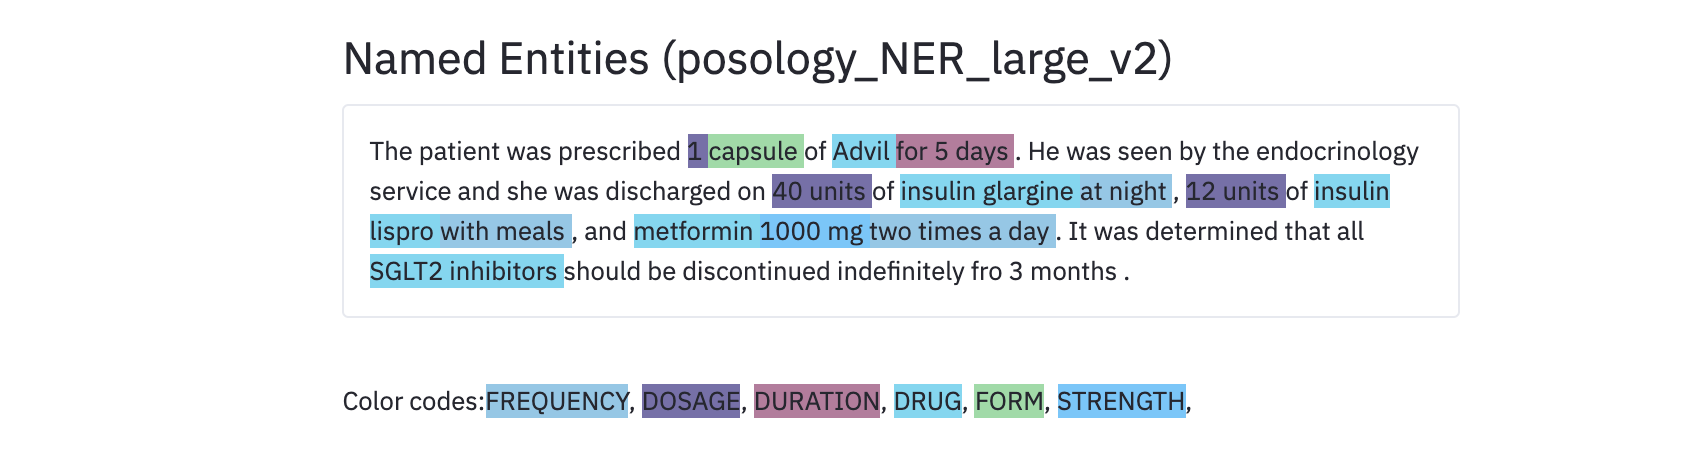

## PHI NER

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'deidentify_dl'

nrows = 100

ner_df = get_clinical_entities (embeddings, pubMedDF, nrows, model_name)

pd_ner_df = ner_df.toPandas()


deidentify_dl download started this may take some time.
[ | ]
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


In [ ]:
pd_ner_df.sample(20)

,id,sentence_id,chunk,begin,end,ner_label
44,44,3,1985,530,533,DATE
18,24,0,Japanand,235,242,DATE
31,31,1,February 2004,178,190,DATE
32,35,1,Logan,473,477,DOCTOR
65,63,0,42,136,137,AGE
64,58,4,Familial,713,720,PATIENT
93,95,3,Alonso,356,361,PATIENT
66,63,1,D9S1748,367,373,DATE
15,22,0,Physalis peruviana,0,17,DOCTOR
76,77,1,Florida,170,176,STATE


In [ ]:
pd_ner_df.ner_label.value_counts()

DATE          37
HOSPITAL      26
AGE            8
COUNTRY        6
PATIENT        5
DOCTOR         5
CITY           3
STATE          2
PROFESSION     2
STREET         1
Name: ner_label, dtype: int64

## BioNLP (Cancer Genetics) NER

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_bionlp'

nrows = 100

ner_df = get_clinical_entities (embeddings, pubMedDF, nrows, model_name)

ner_df.show(truncate = False)

ner_bionlp download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
+---+-----------+----------------------+-----+---+--------------------+
|id |sentence_id|chunk                 |begin|end|ner_label           |
+---+-----------+----------------------+-----+---+--------------------+
|0  |0          |human                 |4    |8  |Organism            |
|0  |0          |Kir 3.3               |17   |23 |Gene_or_gene_product|
|0  |0          |GIRK3                 |26   |30 |Gene_or_gene_product|
|0  |0          |potassium             |92   |100|Simple_chemical     |
|0  |0          |GIRK                  |103  |106|Gene_or_gene_product|
|0  |1          |chromosome 1q21-23    |188  |205|Cellular_component  |
|0  |5          |pancreas              |697  |704|Organ               |
|0  |5          |tissues               |740  |746|Tissue              |
|0  |5  

## Training your own NER Model

In [ ]:
!wget https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/ner/groningen_name_bank_conll/gnm_ner_dataset.csv

--2020-04-09 18:33:30--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/ner/groningen_name_bank_conll/gnm_ner_dataset.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.1.150
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.1.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15208151 (15M) [text/csv]
Saving to: ‘gnm_ner_dataset.csv’

gnm_ner_dataset.csv 100%[===================>]  14.50M  44.4MB/s    in 0.3s    

2020-04-09 18:33:31 (44.4 MB/s) - ‘gnm_ner_dataset.csv’ saved [15208151/15208151]



In [ ]:
import pandas as pd

df = pd.read_csv('gnm_ner_dataset.csv', encoding = "ISO-8859-1", error_bad_lines=False)

In [ ]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
df.Tag.value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [ ]:
df[df.Tag=='B-nat']

,Sentence #,Word,POS,Tag
2723,NaN,H5N1,NNP,B-nat
4554,NaN,H5N1,NNP,B-nat
5044,NaN,Jing,NNP,B-nat
5073,NaN,Jing,NNP,B-nat
5606,NaN,H5N1,NNP,B-nat
...,...,...,...,...
1030042,NaN,Antarctic,NNP,B-nat
1030046,NaN,ACC,NNP,B-nat
1030078,NaN,ACC,NNP,B-nat
1032939,NaN,Katrina,NNP,B-nat


In [ ]:
df['Sentence #'].value_counts()

Sentence: 47577    1
Sentence: 15650    1
Sentence: 28316    1
Sentence: 47639    1
Sentence: 21681    1
                  ..
Sentence: 16205    1
Sentence: 46671    1
Sentence: 28771    1
Sentence: 41892    1
Sentence: 30867    1
Name: Sentence #, Length: 47959, dtype: int64

In [ ]:
df['sentence']=df['Sentence #'].fillna(method='ffill').str.split(expand=True)[1]

In [ ]:
df['sentence'] = df['sentence'].astype(int)

In [ ]:
df.head()

,Sentence #,Word,POS,Tag,sentence
0,Sentence: 1,Thousands,NNS,O,1
1,NaN,of,IN,O,1
2,NaN,demonstrators,NNS,O,1
3,NaN,have,VBP,O,1
4,NaN,marched,VBN,O,1


In [ ]:
df['Tag']=df['Tag'].str.upper()

In [ ]:
df['Tag'].value_counts()

O        887908
B-GEO     37644
B-TIM     20333
B-ORG     20143
I-PER     17251
B-PER     16990
I-ORG     16784
B-GPE     15870
I-GEO      7414
I-TIM      6528
B-ART       402
B-EVE       308
I-ART       297
I-EVE       253
B-NAT       201
I-GPE       198
I-NAT        51
Name: Tag, dtype: int64

In [ ]:
conversion_dict = {'B-TIM':'B-TIME_INDICATOR',
                   'I-TIM':'I-TIME_INDICATOR',
                   'B-GEO':'B-GEOGRAPHICAL_ENTITY',
                   'I-GEO':'I-GEOGRAPHICAL_ENTITY',
                   'B-ORG':'B-ORGANIZATION',
                   'I-ORG':'I-ORGANIZATION',
                   'B-PER':'B-PERSON',
                   'I-PER':'I-PERSON',
                   'B-GPE':'B-GEOPOLITICAL_ENTITY',
                   'I-GPE':'I-GEOPOLITICAL_ENTITY',
                   'B-ART':'B-ARTIFACT',
                   'I-ART':'I-ARTIFACT',
                   'B-EVE':'B-EVENT',
                   'I-EVE':'I-EVENT',
                   'B-NAT':'B-NATURAL_PHENOMENON',
                   'I-NAT':'I-NATURAL_PHENOMENON'}

df['Tag'] = df['Tag'].replace(conversion_dict)

In [ ]:
df['Tag'].value_counts()

O                        887908
B-GEOGRAPHICAL_ENTITY     37644
B-TIME_INDICATOR          20333
B-ORGANIZATION            20143
I-PERSON                  17251
B-PERSON                  16990
I-ORGANIZATION            16784
B-GEOPOLITICAL_ENTITY     15870
I-GEOGRAPHICAL_ENTITY      7414
I-TIME_INDICATOR           6528
B-ARTIFACT                  402
B-EVENT                     308
I-ARTIFACT                  297
I-EVENT                     253
B-NATURAL_PHENOMENON        201
I-GEOPOLITICAL_ENTITY       198
I-NATURAL_PHENOMENON         51
Name: Tag, dtype: int64

In [ ]:
df.shape

(1048575, 5)

In [ ]:
conll_lines=["-DOCSTART- -X- -X- O\n\n"]
    
s=1

labels=[]

#Sentence #	Word	POS	Tags

for i,row in df[:100000].iterrows():

    lines = '{} {} {} {}\n'.format(row['Word'], row['POS'], row['POS'], row['Tag'])
    
    labels.append(lines)

    if row['sentence']!= s:

        conll_lines.append("\n")
        s+=1

    conll_lines.append(lines)
    
    if i%1000==0:
        print (i)


conll_lines.append("\n")


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


In [ ]:
for i in conll_lines[:30]:
  print (i, end='')

-DOCSTART- -X- -X- O

Thousands NNS NNS O
of IN IN O
demonstrators NNS NNS O
have VBP VBP O
marched VBN VBN O
through IN IN O
London NNP NNP B-GEOGRAPHICAL_ENTITY
to TO TO O
protest VB VB O
the DT DT O
war NN NN O
in IN IN O
Iraq NNP NNP B-GEOGRAPHICAL_ENTITY
and CC CC O
demand VB VB O
the DT DT O
withdrawal NN NN O
of IN IN O
British JJ JJ B-GEOPOLITICAL_ENTITY
troops NNS NNS O
from IN IN O
that DT DT O
country NN NN O
. . . O

Families NNS NNS O
of IN IN O
soldiers NNS NNS O
killed VBN VBN O


In [ ]:
with open('GMB_NER.conll', 'w') as f:
    for lines in conll_lines:
        f.write(lines)

In [ ]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, './GMB_NER.conll')

conll_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Thousands of demo...|[[document, 0, 14...|[[document, 0, 14...|[[token, 0, 8, Th...|[[pos, 0, 8, NNS,...|[[named_entity, 0...|
|Families of soldi...|[[document, 0, 16...|[[document, 0, 16...|[[token, 0, 7, Fa...|[[pos, 0, 7, NNS,...|[[named_entity, 0...|
|They marched from...|[[document, 0, 67...|[[document, 0, 67...|[[token, 0, 3, Th...|[[pos, 0, 3, PRP,...|[[named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [ ]:
conll_data.count()

4544

In [ ]:
from pyspark.sql import functions as F

conll_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)


+---------------------+-----+
|ground_truth         |count|
+---------------------+-----+
|O                    |84725|
|B-GEOGRAPHICAL_ENTITY|3303 |
|B-ORGANIZATION       |1876 |
|I-PERSON             |1846 |
|B-TIME_INDICATOR     |1823 |
|B-GEOPOLITICAL_ENTITY|1740 |
|B-PERSON             |1668 |
|I-ORGANIZATION       |1470 |
|I-GEOGRAPHICAL_ENTITY|690  |
|I-TIME_INDICATOR     |549  |
|B-ARTIFACT           |75   |
|B-EVENT              |53   |
|I-GEOPOLITICAL_ENTITY|51   |
|I-EVENT              |47   |
|I-ARTIFACT           |43   |
|B-NATURAL_PHENOMENON |30   |
|I-NATURAL_PHENOMENON |11   |
+---------------------+-----+



In [ ]:
(training_data, test_data) = conll_data.randomSplit([0.8, 0.2], seed = 100)
print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 3605
Test Dataset Count: 939


In [ ]:
glove_embeddings = WordEmbeddingsModel.pretrained("glove_100d", "en", "public/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

test_data = glove_embeddings.transform(test_data)

test_data.write.parquet('gnm_test.parquet')

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [ ]:
test_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|          embeddings|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|" I think actuall...|[[document, 0, 19...|[[document, 0, 19...|[[token, 0, 0, ",...|[[pos, 0, 0, ``, ...|[[named_entity, 0...|[[word_embeddings...|
|" Why do n't you ...|[[document, 0, 49...|[[document, 0, 49...|[[token, 0, 0, ",...|[[pos, 0, 0, ``, ...|[[named_entity, 0...|[[word_embeddings...|
|" You cruel beast...|[[document, 0, 31...|[[document, 0, 31...|[[token, 0, 0, ",...|[[pos, 0, 0, ``, ...|[[named_entity, 0...|[[word_embeddings...|
+--------------------+--------------------+--------------------+--------------------+--------------------+

In [ ]:

nerTagger = NerDLApproach()\
  .setInputCols(["sentence", "token", "embeddings"])\
  .setLabelColumn("label")\
  .setOutputCol("ner")\
  .setMaxEpochs(1)\
  .setLr(0.001)\
  .setPo(0.005)\
  .setBatchSize(512)\
  .setRandomSeed(0)\
  .setVerbose(1)\
  .setValidationSplit(0.2)\
  .setEvaluationLogExtended(True) \
  .setEnableOutputLogs(True)\
  .setIncludeConfidence(True)\
  .setTestDataset("gnm_test.parquet")

#   .setGraphFolder('graph/')\

ner_pipeline = Pipeline(stages=[
          glove_embeddings,
          nerTagger
 ])

In [ ]:
%%time

ner_model = ner_pipeline.fit(training_data)

# if you get an error for incompatible TF graph, use 4.1 NerDL-Graph.ipynb notebook to create a graph

CPU times: user 34.1 ms, sys: 6.96 ms, total: 41.1 ms
Wall time: 1min 10s


In [ ]:
! cd ~/annotator_logs && ls -lt


total 4
-rw-r--r-- 1 root root 1956 Apr  9 18:52 NerDLApproach_21d345fae919.log


In [ ]:
!cat ~/annotator_logs/NerDLApproach_21d345fae919.log


Name of the selected graph: ner-dl/blstm_38_100_128_200.pb
Training started, trainExamples: 2884, labels: 17 chars: 82, 


Epoch: 0 started, learning rate: 0.001, dataset size: 2884
Done, 43.69535816 loss: 309.4145, batches: 10
Quality on validation dataset (20.0%), valExamples = 721
time to finish evaluation: 6.303150492
label	 tp	 fp	 fn	 prec	 rec	 f1
B-PERSON	 0	 0	 247	 0.0	 0.0	 0.0
I-NATURAL_PHENOMENON	 0	 0	 2	 0.0	 0.0	 0.0
I-GEOGRAPHICAL_ENTITY	 0	 0	 132	 0.0	 0.0	 0.0
I-GEOPOLITICAL_ENTITY	 0	 0	 9	 0.0	 0.0	 0.0
B-TIME_INDICATOR	 0	 0	 284	 0.0	 0.0	 0.0
I-ORGANIZATION	 0	 0	 207	 0.0	 0.0	 0.0
I-EVENT	 0	 0	 9	 0.0	 0.0	 0.0
I-TIME_INDICATOR	 0	 0	 81	 0.0	 0.0	 0.0
B-GEOGRAPHICAL_ENTITY	 0	 0	 566	 0.0	 0.0	 0.0
B-NATURAL_PHENOMENON	 0	 0	 6	 0.0	 0.0	 0.0
B-EVENT	 0	 0	 10	 0.0	 0.0	 0.0
B-ARTIFACT	 0	 0	 8	 0.0	 0.0	 0.0
B-GEOPOLITICAL_ENTITY	 0	 0	 276	 0.0	 0.0	 0.0
I-ARTIFACT	 0	 0	 4	 0.0	 0.0	 0.0
I-PERSON	 0	 0	 276	 0.0	 0.0	 0.0
B-ORGANIZATION	 0	 0	 284	 0.0	 

In [ ]:
ner_model.stages

[WORD_EMBEDDINGS_MODEL_48cffc8b9a76, NerDLModel_1ee5757d7a41]

In [ ]:
ner_model.stages[1].write().overwrite().save('trained_ner_model')